In [1]:
import json
import urllib.request

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Interview from creator at NYTimes https://www.nytimes.com/2022/01/03/technology/wordle-word-game-creator.html

### Creator's wife curated words down to about 2,500, which is good because it's a manually-checked database of 5 letter words (better than anything else we can find)

### The entire word list can be scraped from the javascript code on the wordle website, separating the ~2,500 curated words (actually 2,315) from the 12,000 (actually 12,972)

In [2]:
# Scrape the original word list from Wordle

with open(r'..\data\raw\raw_wordle_script.txt', encoding='utf-8') as f:
    wordle_script = f.read()
    
raw_word_list = wordle_script.split('var La=[')[1].split('],Ia="present"')[0]

raw_words = raw_word_list.split(',')
wordle_words = []
for raw_word in raw_words:
    word = raw_word.strip('"')
    wordle_words.append(word)

# fix two errors at the intersection of the recognizable words list La and all words list Ta
wordle_words[2314] = 'shave'
wordle_words[2315] = 'aahed'

curated_words = wordle_words[:2315]

with open(r'..\data\processed\wordle_words.json', 'w') as outfile:
    json.dump(wordle_words, outfile)

In [20]:
# Another word list, 2315 words, already scraped from the website:
#     https://docs.google.com/spreadsheets/d/1-M0RIVVZqbeh0mZacdAsJyBrLuEmhKUhNaVAI-7pr2Y/edit#gid=0

In [59]:
# # Another word list on github:
# english = set()
# for line in urllib.request.urlopen(r'https://raw.githubusercontent.com/eneko/data-repository/master/data/words.txt'):
#     try: 
#         word = line.decode('utf-8').split('\n')[0]
#         english.add(word)
#     except AttributeError:
#         pass

In [213]:
# Word list with frequency from Google
# d = {x: [] for x in range(1, 50)}
# for line in urllib.request.urlopen(r'http://norvig.com/google-books-common-words.txt'):
#     word = (line.decode('utf-8')).split('\t')[0].lower()
#     if word in english:
#         d[len(word)].append(word)

In [3]:
# Word list with frequency from Google
flw_with_freq = []  # flw = five letter words
for line in urllib.request.urlopen(r'http://norvig.com/google-books-common-words.txt'):
    line = (line.decode('utf-8')).split('\t')
    word = line[0].lower()
    freq = line[1].split('\n')[0]
    if len(word) == 5:
        flw_with_freq.append((word, freq))

In [4]:
w = pd.DataFrame(wordle_words, columns=['w'])
w['in_wordle'] = w['w'].apply(lambda x: x in wordle_words)
w['in_wordle_curated'] = w['w'].apply(lambda x: x in curated_words)
flwfreqdf = pd.DataFrame(flw_with_freq, columns=['w', 'freq'])
w = w.merge(right=flwfreqdf, left_on='w', right_on='w', how='outer')
w.loc[:, ['in_wordle', 'in_wordle_curated']] = w.loc[:, ['in_wordle', 'in_wordle_curated']].replace(np.nan, False)
w.set_index('w', inplace=True)
w['freq'] = w['freq'].astype('float64')
w

# w.to_csv(r'..\data\processed\wordle_google_freq_word_list.csv')

,in_wordle,in_wordle_curated,freq
w,,,
cigar,True,True,3877425.0
rebut,True,True,508399.0
sissy,True,True,548761.0
humph,True,True,274977.0
awake,True,True,9037710.0
...,...,...,...
kempf,False,False,100070.0
sakha,False,False,100063.0
ekiti,False,False,100063.0


In [5]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'

def make_bow(word_list):
    # bow = Bag Of Words
    bow = {i: {letter: 0 for letter in alphabet} for i in range(5)}
    for char in range(5):
        for word in word_list:
            bow[char][word[char]] += 1
    # normalize each count by dividing by len(word_list)
    for i in bow:
        for char in bow[i]:
            bow[i][char] = bow[i][char]/len(word_list)
    return bow

In [6]:
bow_17k = make_bow(w.index.to_list())
bow_all_wordle = make_bow(w.loc[w['in_wordle']].index.to_list())
bow_curated_wordle = make_bow(w.loc[w['in_wordle_curated']].index.to_list())

all_bow = {'combined_wordle_google': bow_17k, 'all_wordle': bow_all_wordle, 'wordle_curated': bow_curated_wordle}

In [7]:
# with open(r'..\data\processed\bags_of_words.json', 'w') as outfile:
#     json.dump(all_bow, outfile)

## Depending on the word list, your bag of words will look different
### In the entire list (~17k), there are lots of words that end in 'S' 

### Therefore Robust quantile normalizaton is better for visualizing the heatmap without the extreme bias

## However, in order to show this bias (useful for audience) use Robust=False

In [52]:
plt.style.use('seaborn-white')

In [57]:
def make_bow_heatmap(bow, robust=False):
    df = pd.DataFrame(bow)
    h = sns.heatmap(df, 
                    cmap='viridis',
#                   cmap=sns.diverging_palette(220, 20, as_cmap=True),
                    robust=robust,
#                     cbar_kws={'label': 'Letter Frequency'}
                   )
    plt.gcf().set_size_inches((5, 10))
#     plt.xlabel('Character index')
#     plt.ylabel('letter')
#     plt.title('relative frequencies of each letter\nin filtered English dictionary', fontsize=16)
    return h

<AxesSubplot:>

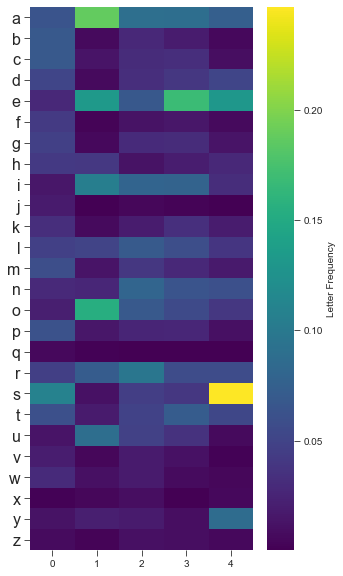

In [31]:
make_bow_heatmap(bow_17k)

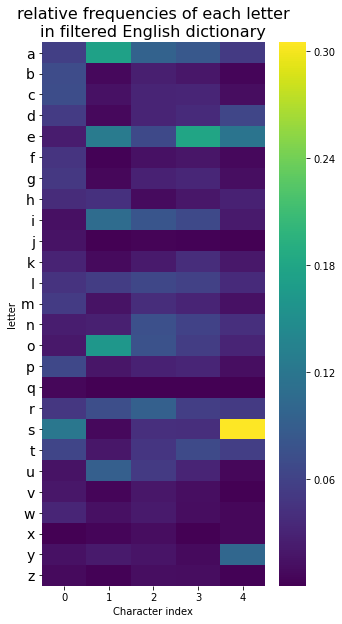

In [18]:
make_bow_heatmap(bow_all_wordle)

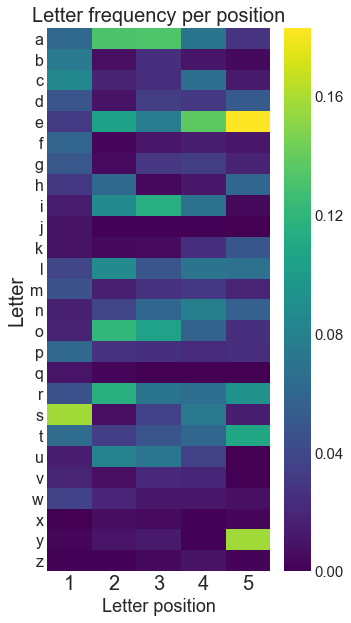

In [56]:
ax = make_bow_heatmap(bow_curated_wordle)
plt.ylabel('Letter', fontsize=20)
plt.xlabel('Letter position', fontsize=18)
plt.xticks([0.5,1.5,2.5,3.5,4.5], [1,2,3,4,5], fontsize=20)
plt.yticks(ticks=[i + 0.5 for i in range(26)], labels=[letter for letter in alphabet], 
           fontsize=16, rotation=0, );
# ax.figure.axes[-1].set_ylabel('Letter Frequency', size=18, rotation=270, loc='center')
ax.figure.axes[-1].tick_params(labelsize=15)
plt.title('Letter frequency per position', fontsize=20)

plt.savefig(r'..\reports\figures\Letter_freq_heatmap.svg', bbox_inches='tight')

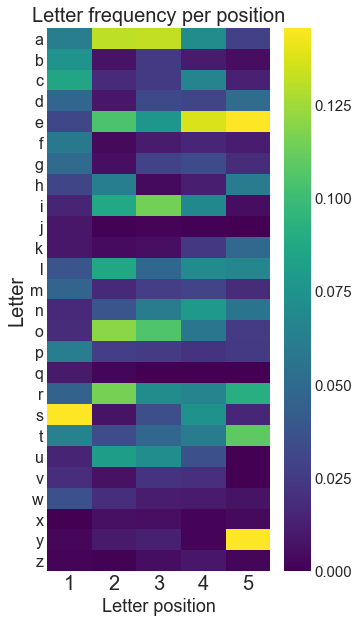

In [59]:
ax = make_bow_heatmap(bow_curated_wordle, robust=True)
plt.ylabel('Letter', fontsize=20)
plt.xlabel('Letter position', fontsize=18)
plt.xticks([0.5,1.5,2.5,3.5,4.5], [1,2,3,4,5], fontsize=20)
plt.yticks(ticks=[i + 0.5 for i in range(26)], labels=[letter for letter in alphabet], 
           fontsize=16, rotation=0, );
# ax.figure.axes[-1].set_ylabel('Letter Frequency', size=18, rotation=270, loc='center')
ax.figure.axes[-1].tick_params(labelsize=15)
plt.title('Letter frequency per position', fontsize=20)

plt.savefig(r'..\reports\figures\Letter_freq_heatmap_ROBUST_TRUE_removes_5e_outlier.svg', bbox_inches='tight')

In [256]:
# with open(r'..\data\processed\filtered_5letter_words.json', 'w') as file:
#     json.dump(d[5], file)

,freq,rel_freq
0,,
which,3140226612,1.000000
their,2152980325,0.685613
there,1623700147,0.517065
would,1472811049,0.469014
other,1383185827,0.440473
...,...,...
kempf,100070,0.000032
sakha,100063,0.000032
ekiti,100063,0.000032


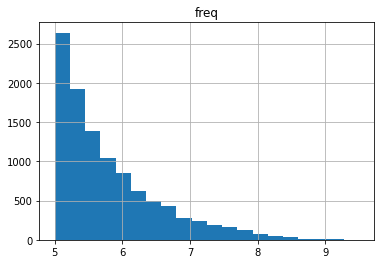

In [111]:
flwfreqdf = pd.DataFrame(flw_with_freq).set_index(0).astype('int64')
flwfreqdf.columns = ['freq'] #.rename({'1': 'freq'}, inplace=True)
# display(flwfreqdf)
np.log10(flwfreqdf).hist(bins=20)
flwfreqdf['rel_freq'] = flwfreqdf / flwfreqdf.max()
flwfreqdf.to_csv(r'..\data\processed\flw_with_frequencies.csv')
flwfreqdf

### The theoretical maximum likelihood of a word using our filtered dictionary as training data is 7.26 e-05 using word 'saaee'

### This is obviously not a word, however. Calculating the likelihoods of our words leads to 'seine' and then 'shree' with maximum likelihood. However, it uses double E, so 'saint' is the best with no duplicate letters

In [139]:
# Calculate likelihood of each word in english dictionary 
result = []
for word in d[5]:
    likelihood = 1
    for i, letter in enumerate(word):
        likelihood *= bow[i][letter]
    result.append((word, likelihood))
        
result = sorted(result, key=lambda x: x[1], reverse=True)

In [140]:
result

[('seine', 2.1411828709166904e-05),
 ('shree', 1.8680108540722916e-05),
 ('saint', 1.6970527428666966e-05),
 ('salle', 1.6529809210665365e-05),
 ('caret', 1.6484064398646927e-05),
 ('slane', 1.5985019212627725e-05),
 ('carer', 1.5842469077741505e-05),
 ('soler', 1.56885839120999e-05),
 ('saute', 1.525999407981246e-05),
 ('sonny', 1.5213794627426583e-05),
 ('sorry', 1.4157128766497412e-05),
 ('sense', 1.3955000141921879e-05),
 ('sauce', 1.3594055861492319e-05),
 ('carse', 1.3258236533145374e-05),
 ('carte', 1.2864983754619875e-05),
 ('slate', 1.2844103156813157e-05),
 ('suite', 1.2786622838156083e-05),
 ('sooty', 1.2768655200103459e-05),
 ('donee', 1.2654879840699366e-05),
 ('puree', 1.2505922257714785e-05),
 ('crane', 1.2410394776161776e-05),
 ('sally', 1.2384483224813147e-05),
 ('salty', 1.206828365311579e-05),
 ('sence', 1.2062796732847725e-05),
 ('borne', 1.1802860824901766e-05),
 ('borer', 1.1678620184639644e-05),
 ('siren', 1.1559418829705552e-05),
 ('cease', 1.13407479583684e-05)

In [149]:
def containsAny(str1, str2, max_repeat=0):
    """ Check whether sequence str1 contains ANY of the letters in str2. """
    set_ = set(x for x in str2)
    return 1 in [c in str1 for c in set_]

In [151]:
containsAny('s', set(['s', 'e', 'i', 'n']))

True

In [154]:
result

[('seine', 2.1411828709166904e-05),
 ('shree', 1.8680108540722916e-05),
 ('saint', 1.6970527428666966e-05),
 ('salle', 1.6529809210665365e-05),
 ('caret', 1.6484064398646927e-05),
 ('slane', 1.5985019212627725e-05),
 ('carer', 1.5842469077741505e-05),
 ('soler', 1.56885839120999e-05),
 ('saute', 1.525999407981246e-05),
 ('sonny', 1.5213794627426583e-05),
 ('sorry', 1.4157128766497412e-05),
 ('sense', 1.3955000141921879e-05),
 ('sauce', 1.3594055861492319e-05),
 ('carse', 1.3258236533145374e-05),
 ('carte', 1.2864983754619875e-05),
 ('slate', 1.2844103156813157e-05),
 ('suite', 1.2786622838156083e-05),
 ('sooty', 1.2768655200103459e-05),
 ('donee', 1.2654879840699366e-05),
 ('puree', 1.2505922257714785e-05),
 ('crane', 1.2410394776161776e-05),
 ('sally', 1.2384483224813147e-05),
 ('salty', 1.206828365311579e-05),
 ('sence', 1.2062796732847725e-05),
 ('borne', 1.1802860824901766e-05),
 ('borer', 1.1678620184639644e-05),
 ('siren', 1.1559418829705552e-05),
 ('cease', 1.13407479583684e-05)

In [185]:
# Based on result, find the sequence of 5 words that contain no repeated letters from the previous words used
for i, (word, likelihood) in enumerate(result): 
    if not containsAny(word, 'saint') and (len(set(word)) == 5):
        print(word, i)
        break

cored 88


## Starting with 'saint', the next best word with the highest likelihood and no repeated letters is 'cored'. After that, 'bulky'. After that there are no words that contain no repeat letters. 

In [198]:
# Allow for x repeat letters
def contains_repeats(word, search, max_repeats):
    s = set(letter for letter in search)
    repeats = 0
    for letter in word:
        if letter in s:
            repeats += 1
    if repeats <= max_repeats:
        return True
    else:
        return False

In [212]:
for i, (word, score) in enumerate(result[2:]):
    if contains_repeats(word, 'saintcoredbulky', 1) and (len(set(word)) >= 4):
        print(word, i)

humph 3348
whiff 3638


## If we allow for 1 repeat letter, then the next best word after 'saint' is 'soler'.

### The next best word with only 1 repeat of characters in 'saintcoredbulky' and 1 double letter in the word is 'humph'

In [227]:
rdf = pd.DataFrame(result, columns=['i', 'l']).set_index('i')
rdf

,l
i,
seine,2.141183e-05
shree,1.868011e-05
saint,1.697053e-05
salle,1.652981e-05
caret,1.648406e-05
...,...
ethyl,1.348889e-09
usque,9.249568e-10
kudzu,6.968371e-10


In [239]:
(rdf.loc['laser'] + rdf.loc['chino'] + rdf.loc['bumpy']).values

array([5.29836631e-06])

In [241]:
(rdf.loc['saint'] + rdf.loc['cored'] + rdf.loc['bulky']).values

array([2.63466779e-05])

In [242]:
2.635e-05 / 5.298e-06

4.973574933937335

In [249]:
df.iloc[18, 0] * 3704

543.0